In [1]:
import sys
print(sys.path)
import os
import numpy as np
import cv2
import glob 
import math
import matplotlib.pyplot as plt
import scipy.misc



['', '/usr/local/lib/python3.5/dist-packages/mask_rcnn-2.1-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/python_pcl-0.3-py3.5-linux-x86_64.egg', '/usr/local/lib/python3.5/dist-packages/nose-1.3.7-py3.5.egg', '/usr/local/lib/python3.5/dist-packages/filelock-3.0.4-py3.5.egg', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/usr/lib/python35.zip', '/usr/lib/python3.5', '/usr/lib/python3.5/plat-x86_64-linux-gnu', '/usr/lib/python3.5/lib-dynload', '/usr/local/lib/python3.5/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.5/dist-packages/IPython/extensions', '/root/.ipython']


/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [2]:
def load_pc_from_bin(path):
    obj = np.fromfile(path,dtype=np.float32).reshape(-1,4)
    return obj



In [3]:
# def read_data(root_path,dataformat='bin'):
#     for line in open(root_path):
#         line = line.strip('\n')
#         raw_data,label_root = line.split(' ')
        
#         if dataformat == 'bin':
#             pc = load_pc_from_bin(raw_data)
        
#         if label_root:
#             with open(label_root,'r') as para:
#                 labels = para.read().strip('\n').split('\n')
#                 bounding_box =[]

#                 for label in labels:
#                     label = label.split(' ')
#                     id = label[0]
#                     if id == ('Car') or id ==('Van'):
#                         label[0] = 0
#                         a = np.append(label[0],label[8:15])
#                         bounding_box.append(a)# need to change followed kitti label format
#                     if id == ('Pedestrain') :
#                         label[0] = 1
#                         a = np.append(label[0], label[8:15])
#                         bounding_box.append(a)

#                     if id =='Cyclist':
#                         label[0] = 2
#                         a = np.append(label[0], label[8:15])
#                         bounding_box.append(a)
#                 print('bbx',bounding_box)
#             if bounding_box:
#                 data = np.array(bounding_box,dtype=np.float32)
#                 index = np.array(data[:, 0], dtype=np.int8)
#                 print('ssss',data.shape)
#                 print('dd',index)
#                 places = data[:,4:7]

#                 size = data[:,1:4]
#                 rotate = data[:,7] # depend on kitti
#     return places,size,rotate

In [4]:
# a,b,c = read_data('test.txt','bin')

In [5]:
def get_dir(root_path):
    bounding_box =[]
    for line in open(root_path):
        line =line.strip('\n')
        data_root,label_root = line.split(' ')
        #para = open(label_root,'r')
        with open(label_root,'r') as para:
            labels = para.read().strip('\n').split('\n')
            print (labels)
            for label in labels:
                label =label.split(' ')
                id = label[0]
                if id == ('Car'):
                    label[0] = 0
                    bounding_box.append(label[0:7])
                if id ==('Pedestrian'):
                    label[0]=1
                    bounding_box.append(label[0:7])
                if id ==('Cyclist'):
                    label[0]=2
                    bounding_box.append(label[0:7])
                
            print (bounding_box)
    if bounding_box:
        data = np.array(bounding_box, dtype=np.float32)
        index = np.array(data[:,0], dtype=np.int8)
        return data[:, 4:7], data[:, 1:4], index

In [6]:
def read_calib_file(calib_path):
    data={}
    with open(calib_path,'r') as f:
        for line in f.readline():
            if not line or line == '\n':
                continue
            key,value = line.split(':',1)
            try:
                data[key] = np.array([float(x) for x in value.split()])
            except ValueError:
                return data

In [7]:
def get_boxcorners(places,size,rotate):
    """assume the point x y z is the bottom center"""
    corners = []
    #print 'test',places,size
    for place, sz, rotation in zip(places, size, rotate):
        x, y, z = place
        h, w, l = sz
        #r_z = rotation
        #print x,y,z
        #print h,w,l

        corner = np.array([
            [x - l / 2., y - w / 2., z],
            [x + l / 2., y - w / 2., z],
            [x - l / 2., y + w / 2., z],
            [x - l / 2., y - w / 2., z + h],
            [x - l / 2., y + w / 2., z + h],
            [x + l / 2., y + w / 2., z],
            [x + l / 2., y - w / 2., z + h],
            [x + l / 2., y + w / 2., z + h],
        ])
        corner -= np.array([x, y, z])

        rotation=np.pi/2 -rotation

        rotate_matrix = np.array([
            [np.cos(rotation), -np.sin(rotation), 0.],
            [np.sin(rotation), np.cos(rotation), 0.],
            [0., 0., 1.]
        ])
        a = np.dot(corner, rotate_matrix.transpose())

        a += np.array([x, y, z])
        corners.append(a)
    return np.array(corners)

In [8]:
def read_mask(SIZE,label,data,location,rotate,method=''):
    """
            [x-w/2.,y-l/2.,z],
            [x+w/2.,y-l/2.,z],
            [x-w/2.,y+l/2.,z],
            [x-w/2.,y-l/2.,z+h],
            [x-w/2.,y+l/2.,z+h],
            [x+w/2.,y+l/2.,z],
            [x+w/2.,y-l/2.,z+h],
            [x+w/2.,y+l/2.,z+h],
    :param points:
    :param data: the pcd point cloud data
    :return :
            data : x y z intensity(now we don't have) distance mask
    """

    assert label.shape[0]== location.shape[0],'the shape are not same'
    bboxs = []
    Alignment_data=[]
    mask=[]
    num_count = 0
    for sz,rotation,place,index in zip(SIZE,rotate,location,label):
        h,w,l = sz
        x,y,z,=place

        bbox = np.array([
            [  w / 2., -l / 2., 0],
            [  w / 2., -l / 2., 0],
            [ -w / 2., +l / 2., 0],
            [ -w / 2., -l / 2., +h],
            [ -w / 2., +l / 2., +h],
            [  w / 2., +l / 2., 0],
            [  w / 2., -l / 2., h],
            [  w / 2., +l / 2., h],
        ])
        Data = data.copy()

        bboxs.append(bbox)
        alig_data = Data[:, 0:3]
        alig_data -= np.array([x, y, z])
        rotation=np.pi/2 -rotation

        rotate_matrix = np.array([
        [np.cos(-rotation), -np.sin(-rotation), 0],
        [np.sin(-rotation), np.cos(-rotation), 0],
        [0, 0, 1]
        ])
        alig_data = np.dot(alig_data, rotate_matrix)
        # please check the data type and rewrite the shape function
        append_zero = np.zeros((alig_data.shape[0], 3))
        alig_data =np.hstack((alig_data, append_zero))

        x_min = -w/2.
        x_max = w/2.
        y_min = -l/2.
        y_max = l/2.
        z_min = 0
        z_max = h
        num_count+=1
        for xyz in alig_data:
            #print 'compare',x_min,xyz[0],x_max
            # data is from the pcd with may dont have the intensity
            xyz[3] = xyz[2]/(np.sqrt((xyz[0]*xyz[0]+xyz[1]*xyz[1]+xyz[2]*xyz[2])))
            xyz[4] = np.sqrt((xyz[0]*xyz[0]+xyz[1]*xyz[1]+xyz[2]*xyz[2]))

            if (x_min<xyz[0]<x_max) and (y_min<xyz[1]<y_max) and (z_min<xyz[2]<z_max):
                #print('indeeeee',index,xyz[1])
                if index ==0:
                    xyz[5]=1 #car
                if index ==1:
                    xyz[5]=2 #person
                if index ==2:
                    xyz[5]=3
            
        if index==0:

            id_1 = np.argwhere(alig_data[:,5]==1)
            #print('a',len(id_1))
            if len(id_1)>50 :
                a=np.append(index,id_1)
            #print('a',a)
                mask.append(a)
        if index==1:
            id_2 = np.argwhere(alig_data[:,5]==2)
            if len(id_2)>30 :
                b=np.append(index,id_2)
                mask.append(b)
        if index==2:
            
            id_3 = np.argwhere(alig_data[:,5]==3)
            if len(id_3)>30 :
                c=np.append(index,id_3)
                mask.append(c)
    MASK = np.array(mask)
    return MASK


def point_mask(mask_index,points):
    n_dim = mask_index.shape[0]
    append_zero_0 = np.zeros((points.shape[0], 1))
    points = np.hstack((points, append_zero_0))
    
    for xyz in points:

        xyz[4] = np.sqrt((xyz[0] * xyz[0] + xyz[1] * xyz[1] + xyz[2] * xyz[2]))
    append_zero = np.zeros((points.shape[0], n_dim))
    points = np.hstack((points, append_zero))
    #print(n_dim)
    for dim in range(n_dim):
        #print('index',dim)
        ins_mask = mask_index[dim]
        label = ins_mask[0]
        #print('class_id',label)
        if label == 0:
            for id in ins_mask[1:]:
                points[id][5+dim]= label + 1
        if label == 1:
            for id in ins_mask[1:]:
                points[id][5+dim] = label + 1
        if label == 2:
            for id in ins_mask[1:]:
                points[id][5+dim] = label + 1           
#     for xyz in points:

#         xyz[4] = np.sqrt((xyz[0] * xyz[0] + xyz[1] * xyz[1] + xyz[2] * xyz[2]))


#     for index in mask_index:
#         label = index[0]
#         # print label
#         if label == 0:
#             for id in index[1:]:
#                 points[id][5] = label + 1
#         if label == 1:
#             for id in index[1:]:
#                 points[id][5] = label + 1
#         if label == 2:
#             for id in index[1:]:
#                 points[id][5] = label + 1   
    
    return points


In [9]:
def filter_camera_angle(places):
    """Filter camera angles for KiTTI Datasets"""
    #bool_in = np.logical_and((places[:, 1] < places[:, 0] - 0.27), (-places[:, 1] < places[:, 0] - 0.27))
    bool_in = np.logical_and((places[:, 1] < places[:, 0]), (-places[:, 1] < places[:, 0]))
    return places[bool_in]

In [10]:
def creat_label_64_512(points,num_height,num_width,v_fov=(-45,45)):
    #assert points.shape[1] == 9,'x,y,z,itensity,distance,mask'
    #x=points[:,0]
    #y=points[:,1]
    #z=points[:,2]
    #dis =points[:,4]

    append_zero = np.zeros((points.shape[0], 2))
    alig_data = np.hstack((points, append_zero))
    len_=alig_data.shape[1]
    for p in alig_data:

        r = np.sqrt(p[0] * p[0] + p[1] * p[1])  # p[0] x
        p[len_-2] = np.arcsin(p[2] / p[4])            # p[1] y
        p[len_-1] = np.arcsin(p[1] / r)    # fie
        # p[2] z  p[4] dis

    theta =alig_data[:,len_-2]
    fie   =alig_data[:,len_-1]
    t_a=theta.max()
    t_i= theta.min()
    f_a=fie.max()
    f_i=fie.min()
    t_range = (t_a - t_i)
    f_range = (f_a - f_i)

    resolution_h = t_range / num_height
    resolution_w = (f_range)/ num_width

    x_min = (f_i)/resolution_w
    y_min = (t_i)/resolution_h
    #print 'shift',y_min,x_min
    #print 'angle',theta,fie
    #print 'range',t_range,f_range
    #print'resl', resolution_h,resolution_w


    append_64 = np.zeros((num_height,num_width,len_-2))
    # len(mask_isntance) = len_ -2 -5(x,y,z,itensity,dis)
    mask_ins = len_ - 2 - 5
    print('ins',mask_ins)
    for p in alig_data:
        #print 'check',t_i,p[7],t_a
                index_h=(p[len_-2]/resolution_h-y_min)
                index_w=(p[len_-1]/resolution_w-x_min)
                shitf_h =-round(index_h-num_height)
                #shitf_h=math.floor(shitf_h)
                #print 't_i',p[7],resolution_w
                #print 'check',index_w,math.floor(index_w),round(x_min)
                shitf_w = -round(index_w-num_width)
                #if shitf_h > 64 :
                    #print 'error', shitf_h
                   # print y_min
                #if shitf_w>512:
                    #print 'wrong',shitf_w
                #shitf_w =math.floor(shitf_w)
                #shitf_h=abs(-shitf_h)
                #shitf_w=abs(-shitf_w)
                #print shitf_h,shitf_w
                append_64[int(shitf_h) - 1, int(shitf_w) - 1, 0] = p[0]  # x
                append_64[int(shitf_h) - 1, int(shitf_w) - 1, 1] = p[1]  # y
                append_64[int(shitf_h) - 1, int(shitf_w) - 1, 2] = p[2]  # z
                append_64[int(shitf_h) - 1, int(shitf_w) - 1, 3] = p[3]  # in
                append_64[int(shitf_h) - 1, int(shitf_w) - 1, 4] = p[4]  # dis
#                 append_64[int(shitf_h) - 1, int(shitf_w) - 1, 5] = p[5]  # mask
                for num in range(mask_ins):
                    #print('index',num)
                    append_64[int(shitf_h) - 1, int(shitf_w) - 1, num+5] = p[5+num]
    #plt.figure(num='test',figsize=(8,8))
    #return append_64
   # plt.subplot(4,1,1)
    #plt.imshow(append_64[:,:,9])
    #plt.subplot(4,1,2)
   # plt.imshow(append_64[:,:,6])
    
    
    #plt.show()
    return append_64

In [11]:

def check_filter_points(points):
    points=filter_camera_angle(points)
    return points

In [12]:
def process(root_path,calib_path,dataformat='bin',method='',type=''):
    p = []
    pc = None
    bounding_boxes = None
    places = None
    size = None
    for line in open(root_path):
        line = line.strip('\n')
        raw_data,label_root = line.split(' ')
        
        if dataformat == 'bin':
            pc = load_pc_from_bin(raw_data)
        
        if label_root:
            with open(label_root,'r') as para:
               # print('root',label_root)
                labels = para.read().strip('\n').split('\n')
                
                bounding_box=[]
                for label in labels:
                    label = label.split(' ')
                    id = label[0]
                    if id == ('Car') or id ==('Van'):
                        label[0] = 0
                        a = np.append(label[0],label[8:15])
                        bounding_box.append(a)# need to change followed kitti label format
                    if id == ('Pedestrian') :
                        label[0] = 1
                        print('get')
                        a = np.append(label[0], label[8:15])
                        bounding_box.append(a)

                    if id =='Cyclist':
                        label[0] = 2
                        a = np.append(label[0], label[8:15])
                        bounding_box.append(a)
                if bounding_box:
                    data = np.array(bounding_box,dtype=np.float32)
                    index = np.array(data[:, 0], dtype=np.int8)
                    places = data[:,4:7]

                    size = data[:,1:4]
                    rotate = data[:,7] # depend on kitti
                #print(data)
                if calib_path:
                    if type=='kitti_obj':
                        calib = read_calib_file(calib_path)
                        pro_j_velo=proj_to_velo(calib)[:,:3]
                        places = np.dot(places,pro_j_velo.transpose())[:,:3]
                    #places[:,0] +=0.27
                    if type =='kitti_raw':
                        #Calib=read_raw_calib_file(calib_path)
                        #proj_raw_data = proj_raw(Calib)[:,:3]
                        #places = np.dot(places, proj_raw_data.transpose())[:, :3]
                        continue
                        
                        
                pc = filter_camera_angle(pc)
                shape = pc.shape
                #corners = get_boxcorners(places,size,rotate)
                #print('cor',corners)
                Pc_ = pc.copy()
                Mask = read_mask(size,index,Pc_,places,rotate)
                #print('mask',Mask)
                if len(Mask)>0:
                    Mask_point = point_mask(Mask,pc)
                    #print('mask',Mask_point.shape)
                
                    store_npy =creat_label_64_512(Mask_point, 64, 512, v_fov=(-45, 45))
                #print (store_npy.shape) #0 1 2 3 4 5      6    7 ------
                                        #x y z i d ob_1   ob_2 ob_3
                    xyz_in_dis = store_npy[:,:,:4]
                    shape = store_npy.shape
                    mask =store_npy[:,:,5:shape[2]]
                #print(np.where(mask[:,:,4]==3))
                    #print('a',mask.shape)
                    if len(mask) > 0:
                        id_name = para.name[36:62]
                        id_root = para.name[69:79]
                        file_name = id_name+'_'+id_root
                        root = 'Kitti'
                        raw_root = '/data'
                        label_root = '/npylabel'
                        npy ='/npydata'
                        if os.path.exists(root+npy) is False:
                            os.makedirs(root+npy)
                            os.makedirs(root+label_root)
                        else:
                    #assert xyz_in_dis.shape[2] == 5
                            np.save(root+npy+'/'+file_name,xyz_in_dis)
                        #scipy.misc.imsave(root+raw_root+'/'+file_name+'.jpg',xyz_in_dis)
                            np.save(root+label_root+'/'+file_name,mask)

In [13]:
root ='test.txt'
calib = 'Kitti/2011_09_26/calib_velo_to_cam.txt'
process(root,calib)

get
ins 1
get
ins 2
get
ins 2
ins 2
get
get
ins 1
get
ins 1
get
ins 1
get
ins 2
get
get
ins 1
get
get
get
ins 1
get
ins 2
get
get
ins 1
ins 2
get
get
get
ins 1
get
get
ins 2
get
ins 2
get
get
ins 2
get
ins 2
get
ins 2
ins 2
get
get
get
get
get
get
ins 1
get
get
ins 2
get
get
get
get
ins 1
get
get
get
ins 2
get
ins 2
get
get
ins 1
get
get
ins 2
ins 2
get
get
get
ins 2
get
get
ins 2
get
get
ins 1
ins 2
get
get
ins 2
get
ins 2
get
ins 2
get
ins 2
get
get
ins 2
get
ins 1
get
ins 1
get
ins 1
get
ins 2
ins 1
ins 2
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 2
ins 1
ins 2
ins 1
ins 1
get
ins 1
get
ins 1
ins 2
get
ins 1
ins 1
get
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
get
get
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
get
ins 2
ins 1
ins 1
ins 1
get
ins 2
ins 1
get
ins 2
ins 2
ins 1
ins 1
get
in

ins 3
ins 2
ins 3
ins 6
ins 4
ins 3
ins 3
ins 2
ins 4
ins 4
ins 5
ins 3
ins 2
ins 1
ins 7
ins 3
ins 2
ins 4
ins 2
ins 3
ins 3
ins 3
ins 3
ins 6
ins 3
ins 3
ins 2
ins 5
ins 3
ins 3
ins 4
ins 4
ins 2
ins 3
ins 1
ins 3
ins 3
ins 4
ins 2
ins 3
ins 3
ins 5
ins 3
ins 5
ins 1
ins 1
ins 3
ins 1
ins 5
ins 4
ins 1
ins 2
ins 1
ins 2
ins 3
ins 4
ins 2
ins 3
ins 4
ins 3
ins 2
ins 2
ins 1
ins 5
ins 6
ins 3
ins 3
ins 3
ins 2
ins 2
ins 3
ins 4
ins 2
ins 3
ins 2
ins 4
ins 3
ins 3
ins 3
ins 4
ins 2
ins 1
ins 3
ins 2
ins 3
ins 2
ins 2
ins 2
ins 2
ins 3
ins 2
ins 2
ins 4
ins 2
ins 4
ins 3
ins 2
ins 4
ins 3
ins 3
ins 6
ins 4
ins 2
ins 3
ins 3
ins 3
ins 2
ins 1
ins 4
ins 4
ins 3
ins 3
ins 2
ins 2
ins 2
ins 3
ins 1
ins 3
ins 4
ins 4
ins 3
ins 3
ins 2
ins 2
ins 2
ins 3
ins 3
ins 6
ins 1
ins 4
ins 2
ins 2
ins 2
ins 3
ins 2
ins 3
ins 4
ins 3
ins 2
ins 2
ins 5
ins 3
ins 1
ins 5
ins 2
ins 3
ins 2
ins 5
ins 2
ins 6
ins 5
ins 5
ins 3
ins 2
ins 4
ins 3
ins 3
ins 1
ins 6
ins 4
ins 3
ins 6
ins 4
ins 3
ins 2
ins 3
ins 

ins 3
ins 1
ins 4
ins 4
ins 3
ins 4
ins 3
ins 3
get
ins 3
ins 3
get
ins 4
ins 4
ins 7
get
ins 3
get
ins 4
get
ins 3
get
ins 2
ins 3
ins 2
ins 3
ins 3
ins 2
ins 1
ins 2
get
ins 4
ins 4
ins 4
ins 3
ins 3
get
ins 3
ins 6
ins 4
ins 5
ins 2
ins 4
ins 6
ins 1
ins 1
get
ins 4
ins 3
get
ins 4
ins 4
ins 2
ins 7
ins 4
ins 3
ins 4
ins 4
ins 4
ins 1
ins 4
ins 2
ins 3
ins 3
get
get
ins 5
ins 1
get
ins 4
get
ins 3
ins 4
ins 3
ins 1
ins 3
ins 3
ins 5
get
ins 5
ins 3
get
get
ins 4
ins 2
ins 5
ins 4
ins 2
ins 2
ins 1
ins 7
ins 3
get
ins 5
ins 5
ins 3
ins 6
ins 2
ins 4
ins 4
ins 3
ins 4
get
ins 2
ins 5
get
ins 3
get
ins 4
ins 5
ins 3
ins 3
ins 4
ins 2
ins 3
ins 4
ins 4
ins 7
ins 6
get
ins 4
ins 4
ins 3
ins 4
ins 5
get
get
ins 5
ins 1
ins 3
get
ins 4
ins 6
ins 6
ins 6
ins 6
ins 1
ins 6
ins 4
ins 3
get
ins 2
ins 4
ins 4
ins 4
ins 4
ins 1
ins 1
ins 3
ins 2
get
get
ins 6
get
get
ins 3
ins 3
get
ins 4
ins 3
ins 4
get
ins 2
ins 2
get
ins 4
ins 3
get
get
ins 5
ins 2
ins 2
ins 3
ins 3
ins 3
ins 4
get
ins 4
get


ins 5
ins 1
get
get
get
get
ins 4
get
get
get
get
get
get
get
ins 7
get
get
get
ins 3
get
get
ins 2
get
get
get
ins 2
get
get
get
get
get
ins 8
get
get
ins 3
get
get
get
get
ins 6
get
get
ins 6
get
get
ins 5
get
get
get
ins 3
get
get
get
ins 2
get
get
get
get
get
ins 5
get
get
ins 2
get
get
get
ins 3
get
get
get
get
get
ins 5
get
get
get
ins 3
get
get
get
get
get
get
get
ins 7
ins 1
ins 1
get
get
get
get
get
ins 10
get
get
ins 4
ins 1
get
get
get
get
ins 6
get
get
get
get
get
ins 5
get
get
get
get
get
ins 8
get
ins 3
get
get
get
get
ins 6
ins 1
get
get
ins 4
get
get
get
get
get
ins 5
get
get
get
get
ins 6
get
get
ins 4
get
get
get
get
ins 4
get
get
ins 2
ins 1
get
get
get
get
get
ins 7
get
get
get
get
get
ins 7
get
get
get
get
get
ins 6
get
get
ins 2
get
get
get
get
get
ins 6
get
get
get
get
ins 4
get
get
get
get
get
get
ins 6
get
get
get
get
get
ins 7
get
get
get
ins 5
get
get
ins 2
get
get
ins 2
get
get
get
get
ins 4
get
get
get
get
ins 4
get
get
get
get
get
ins 5
get
get
ins 2
get
g

ins 7
get
get
get
get
ins 5
ins 8
get
get
get
ins 7
ins 6
ins 7
ins 4
ins 6
ins 7
ins 2
ins 1
ins 7
ins 6
ins 7
get
get
get
get
ins 6
ins 7
ins 1
ins 7
ins 7
ins 7
ins 6
ins 3
ins 7
ins 4
ins 7
ins 6
ins 7
ins 2
ins 6
ins 8
ins 2
ins 3
ins 7
ins 6
get
get
get
get
ins 7
ins 2
ins 6
ins 8
ins 5
get
get
get
get
ins 8
ins 7
ins 2
ins 7
ins 4
ins 1
ins 4
ins 2
ins 5
ins 2
ins 7
ins 6
get
get
get
get
ins 7
ins 2
ins 7
get
get
get
get
ins 8
ins 5
ins 1
ins 8
ins 2
ins 1
ins 7
ins 8
ins 1
ins 5
ins 7
ins 7
ins 5
ins 1
ins 4
ins 7
get
get
get
ins 4
ins 7
get
get
get
get
ins 7
ins 7
ins 3
ins 7
ins 6
ins 7
ins 6
ins 1
ins 3
ins 6
ins 8
ins 6
ins 7
ins 2
ins 7
get
get
get
get
ins 6
get
get
get
ins 7
ins 2
get
get
get
get
ins 8
ins 8
ins 8
ins 9
ins 7
get
get
get
get
ins 6
ins 5
ins 7
get
get
get
get
ins 5
ins 2
get
get
get
get
ins 8
ins 6
ins 7
ins 4
ins 4
ins 8
get
get
get
ins 6
ins 6
get
get
get
get
ins 8
get
get
get
ins 3
ins 7
ins 7
ins 7
ins 7
ins 7
ins 2
ins 4
ins 8
ins 7
ins 2
ins 8
ins 2


ins 7
ins 9
ins 11
ins 10
ins 12
ins 14
ins 10
ins 9
ins 11
ins 8
ins 10
ins 12
ins 9
ins 9
ins 13
ins 11
ins 11
ins 7
ins 11
ins 11
ins 6
ins 9
ins 13
ins 8
get
get
ins 10
ins 8
ins 13
ins 9
ins 11
ins 11
ins 9
ins 11
ins 7
get
get
ins 10
ins 11
ins 11
ins 12
ins 10
ins 11
ins 8
ins 11
ins 10
ins 9
ins 12
ins 9
ins 11
ins 10
ins 11
ins 8
ins 7
ins 10
ins 10
ins 9
ins 8
ins 15
ins 11
ins 9
ins 12
ins 10
ins 6
ins 7
ins 11
ins 11
ins 11
ins 11
ins 13
ins 8
ins 13
ins 7
ins 11
ins 11
ins 12
ins 12
ins 8
ins 7
ins 6
ins 11
ins 11
ins 7
ins 10
ins 13
ins 14
ins 8
ins 9
get
ins 9
ins 6
ins 7
ins 9
ins 11
ins 9
ins 11
ins 8
ins 11
ins 11
ins 10
ins 11
ins 7
ins 7
ins 8
ins 11
ins 13
ins 11
ins 7
ins 9
ins 14
ins 8
ins 11
ins 11
ins 13
ins 7
ins 9
get
get
ins 10
ins 12
ins 10
ins 9
ins 9
ins 13
ins 7
ins 12
ins 12
ins 11
ins 8
ins 8
ins 8
ins 10
ins 11
ins 12
get
get
ins 9
ins 7
ins 4
ins 4
ins 3
ins 7
ins 7
ins 5
ins 5
get
ins 5
ins 1
ins 7
get
ins 5
ins 3
get
ins 6
ins 10
get
get
ins 7
ins 

ins 3
ins 1
ins 5
get
ins 2
ins 4
ins 4
ins 3
ins 1
ins 5
ins 1
ins 6
ins 5
ins 4
ins 1
ins 1
ins 4
ins 6
ins 1
ins 5
ins 4
get
ins 5
ins 6
ins 5
ins 6
ins 1
ins 3
ins 5
ins 1
ins 4
ins 4
ins 2
ins 4
ins 6
ins 4
ins 5
ins 5
ins 3
ins 3
ins 7
ins 4
ins 4
ins 3
get
ins 6
get
ins 6
ins 2
ins 3
ins 3
ins 5
get
ins 3
get
ins 1
ins 1
ins 4
get
ins 2
ins 1
get
ins 3
ins 3
ins 3
ins 1
ins 2
ins 1
ins 1
ins 4
ins 5
ins 1
ins 1
ins 1
ins 1
ins 1
ins 3
ins 1
ins 1
ins 1
ins 2
ins 3
ins 1
ins 5
ins 3
ins 1
get
ins 1
ins 1
get
ins 1
ins 4
ins 5
ins 5
ins 4
ins 2
ins 4
ins 1
ins 7
ins 3
ins 5
get
ins 2
ins 4
get
ins 2
get
ins 2
ins 1
get
ins 5
ins 2
ins 1
ins 3
get
ins 1
ins 5
ins 5
get
ins 2
ins 4
ins 2
get
ins 3
get
ins 5
ins 4
ins 2
ins 4
ins 5
ins 1
ins 4
ins 1
ins 3
ins 5
ins 1
ins 3
ins 1
ins 4
ins 3
ins 1
ins 3
ins 6
ins 6
ins 6
ins 2
ins 1
ins 4
ins 5
get
ins 6
ins 4
get
ins 1
ins 5
ins 7
ins 1
ins 1
ins 1
ins 7
ins 5
ins 3
ins 5
ins 5
ins 1
ins 4
ins 2
ins 1
ins 1
ins 5
ins 1
ins 2
ins 1
in

ins 2
get
ins 5
ins 1
ins 2
ins 3
ins 2
ins 1
get
ins 3
get
get
ins 6
ins 2
ins 2
ins 2
get
ins 2
ins 5
ins 3
ins 4
ins 1
ins 1
ins 2
ins 1
ins 3
ins 1
ins 1
ins 2
ins 7
ins 4
ins 1
ins 3
ins 1
ins 5
ins 3
ins 2
ins 6
get
ins 5
ins 4
ins 3
ins 3
ins 5
ins 1
ins 2
ins 6
get
ins 5
ins 2
ins 2
ins 2
ins 4
ins 1
ins 5
ins 3
ins 4
ins 2
ins 4
ins 1
ins 3
ins 4
ins 1
ins 2
ins 2
ins 3
get
ins 6
ins 2
ins 1
ins 3
get
ins 5
ins 2
ins 5
ins 1
ins 1
ins 1
ins 3
ins 2
ins 2
ins 2
ins 3
ins 3
ins 3
ins 2
ins 1
ins 1
ins 1
ins 2
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 2
ins 1
ins 2
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 2
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 1
ins 



root ='/usr/app/code/data/Kitti/label'
file = os.listdir(root)
print(file)
d=root+'/'+file[3]
print(d)

In [104]:
a= np.load(d)

In [105]:
print(a.shape)

(64, 512, 4)


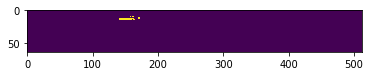

In [106]:
plt.imshow(a[:,:,1])


In [107]:
n = np.max(a.reshape(-1,a.shape[2]),0)
print(n.shape,n)

(4,) [1. 1. 1. 1.]
